In [1]:
import os
print(os.getcwd())
os.chdir("C:\\Users\\peter\\Projects\\pricer")
print(os.getcwd())

C:\Users\peter\Projects\jupyter
C:\Users\peter\Projects\pricer


In [2]:
import copy
import numpy as np
import pandas as pd
from securities.bonds import Bond
from securities.options import (
    EuropeanCall,
    EuropeanPut,
    AmericanCall,
    AmericanPut,
)
from securities.analytics import (
    DefaultProbability,
    OptionalConvProbability,
    MaturityConvProbability,
    CallRedemptionProbability,
    ForcedConvProbability,
    PutProbability,
    MaturityRedemptionProbability,
)
from securities.converts import ConvertibleBond
from models.binomial_tree import BinomialTree
from models.monte_carlo import MonteCarlo
from models.pde import PDE
from objects.events import Event
from utils.pricing_utils import bs_call, bs_put
import matplotlib.pyplot as plt
from calculation import calculator
import matplotlib.ticker as mticker

Vanilla Options

In [3]:
strike = 100
maturity = 1.0
stock_price = 100
equity_vol = 0.3
riskless_rate = 0.1
dividend_yield = 0.05
default_intensity = 0.5
equity_to_credit = 2.0
stock_ladder = np.linspace(1.0, stock_price * 3.0, 300)
price_ladder = {}

In [4]:
%%time
# Model
crr_model = BinomialTree(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    spline_size=500,
    time_size=1000,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
pde_model = PDE(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    time_size=1000,
    space_size=3000,
    min_space=120.0,
    max_space=120,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
# Security
ec = EuropeanCall(strike=strike, maturity=maturity)
ep = EuropeanPut(strike=strike, maturity=maturity)
ac = AmericanCall(strike=strike, maturity=maturity)
ap = AmericanPut(strike=strike, maturity=maturity)
# Pricing
price_ladder["EC"] = {}
price_ladder["EC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ec)[0])
price_ladder["EC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ec)[0])
price_ladder["EC"]["BS"] = bs_call(stock_ladder, strike, maturity, riskless_rate, dividend_yield, default_intensity, equity_vol)
price_ladder["EC"]["Payoff"] = np.maximum(stock_ladder - strike, 0)

price_ladder["EP"] = {}
price_ladder["EP"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ep)[0])
price_ladder["EP"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ep)[0])
price_ladder["EP"]["BS"] = bs_put(stock_ladder, strike, maturity, riskless_rate, dividend_yield, default_intensity, equity_vol)
price_ladder["EP"]["Payoff"] = np.maximum(strike - stock_ladder, 0)

price_ladder["AC"] = {}
price_ladder["AC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ac)[0])
price_ladder["AC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ac)[0])
price_ladder["AC"]["BS"] = bs_call(stock_ladder, strike, maturity, riskless_rate, dividend_yield, default_intensity, equity_vol)
price_ladder["AC"]["Payoff"] = np.maximum(stock_ladder - strike, 0)

price_ladder["AP"] = {}
price_ladder["AP"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ap)[0])
price_ladder["AP"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ap)[0])
price_ladder["AP"]["BS"] = bs_put(stock_ladder, strike, maturity, riskless_rate, dividend_yield, default_intensity, equity_vol)
price_ladder["AP"]["Payoff"] = np.maximum(strike - stock_ladder, 0)

CPU times: total: 2.98 s
Wall time: 3.17 s


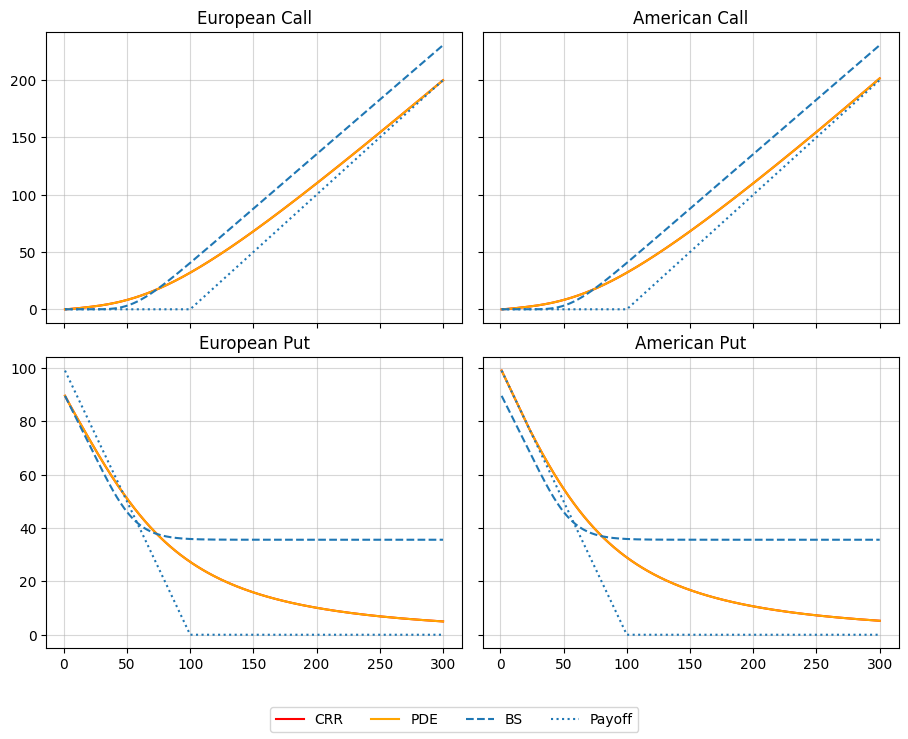

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey="row")

subplot_map = {
    "EC": [0, 0, "European Call"],
    "AC": [0, 1, "American Call"],
    "EP": [1, 0, "European Put"],
    "AP": [1, 1, "American Put"],
}
for ctype, d in price_ladder.items():
    row = subplot_map[ctype][0]
    col = subplot_map[ctype][1]
    title = subplot_map[ctype][2]
    for model, ladder in d.items():
        linestyle = ":" if model == "Payoff" else "--" if model == "BS" else "-"
        color = "red" if model == "CRR" else "orange" if model == "PDE" else "#1f77b4"
        axes[row, col].plot(stock_ladder, ladder, label=model, linestyle=linestyle, color=color)
    axes[row, col].set_title(title)
    axes[row, col].grid(alpha=0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center")
fig.subplots_adjust(wspace=0.05, hspace=0.12)

Straight Bond

In [6]:
maturity = 1.0
face_value = 100
coupon_schedule = {0.25: 2.0, 0.5: 2.0, 0.75: 2.0, 1.0: 2.0}
call_schedule = {(0.5, 1.0): 90}
put_schedule = {(0.5, 1.0): 85}
recovery_rate = 0.3
recovery_type = "par"
stock_price = 100
equity_vol = 0.3
riskless_rate = 0.1
dividend_yield = 0.05
default_intensity = 0.5
equity_to_credit = 2.0
stock_ladder = np.linspace(10.0, stock_price * 10.0, 300)
price_ladder = {}

In [7]:
%%time
# Model
crr_model = BinomialTree(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    spline_size=500,
    time_size=1000,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
pde_model = PDE(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    time_size=1000,
    space_size=3000,
    min_space=120.0,
    max_space=120,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
# Security
zb = Bond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule={},
    call_schedule={},
    put_schedule={},
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
)
cb = Bond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    call_schedule={},
    put_schedule={},
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
)
ccb = Bond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    call_schedule=call_schedule,
    put_schedule={},
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
)
cpcb = Bond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    call_schedule=call_schedule,
    put_schedule=put_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
)
# Pricing
price_ladder["ZB"] = {}
price_ladder["ZB"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(zb)[0])
price_ladder["ZB"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(zb)[0])
price_ladder["ZB"]["RiskfreePV"] = np.full_like(stock_ladder, zb.get_riskfree_bond_floor(crr_model, Event(crr_model, zb))[0])
price_ladder["ZB"]["RiskyPV"] = np.full_like(stock_ladder, zb.get_risky_bond_floor(crr_model, Event(crr_model, zb))[0])

price_ladder["CB"] = {}
price_ladder["CB"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cb)[0])
price_ladder["CB"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cb)[0])
price_ladder["CB"]["RiskfreePV"] = np.full_like(stock_ladder, cb.get_riskfree_bond_floor(crr_model, Event(crr_model, cb))[0])
price_ladder["CB"]["RiskyPV"] = np.full_like(stock_ladder, cb.get_risky_bond_floor(crr_model, Event(crr_model, cb))[0])

price_ladder["CCB"] = {}
price_ladder["CCB"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ccb)[0])
price_ladder["CCB"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ccb)[0])
price_ladder["CCB"]["RiskfreePV"] = np.full_like(stock_ladder, ccb.get_riskfree_bond_floor(crr_model, Event(crr_model, ccb))[0])
price_ladder["CCB"]["RiskyPV"] = np.full_like(stock_ladder, ccb.get_risky_bond_floor(crr_model, Event(crr_model, ccb))[0])

price_ladder["CPCB"] = {}
price_ladder["CPCB"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cpcb)[0])
price_ladder["CPCB"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cpcb)[0])
price_ladder["CPCB"]["RiskfreePV"] = np.full_like(stock_ladder, cpcb.get_riskfree_bond_floor(crr_model, Event(crr_model, cpcb))[0])
price_ladder["CPCB"]["RiskyPV"] = np.full_like(stock_ladder, cpcb.get_risky_bond_floor(crr_model, Event(crr_model, cpcb))[0])

CPU times: total: 2.69 s
Wall time: 2.71 s


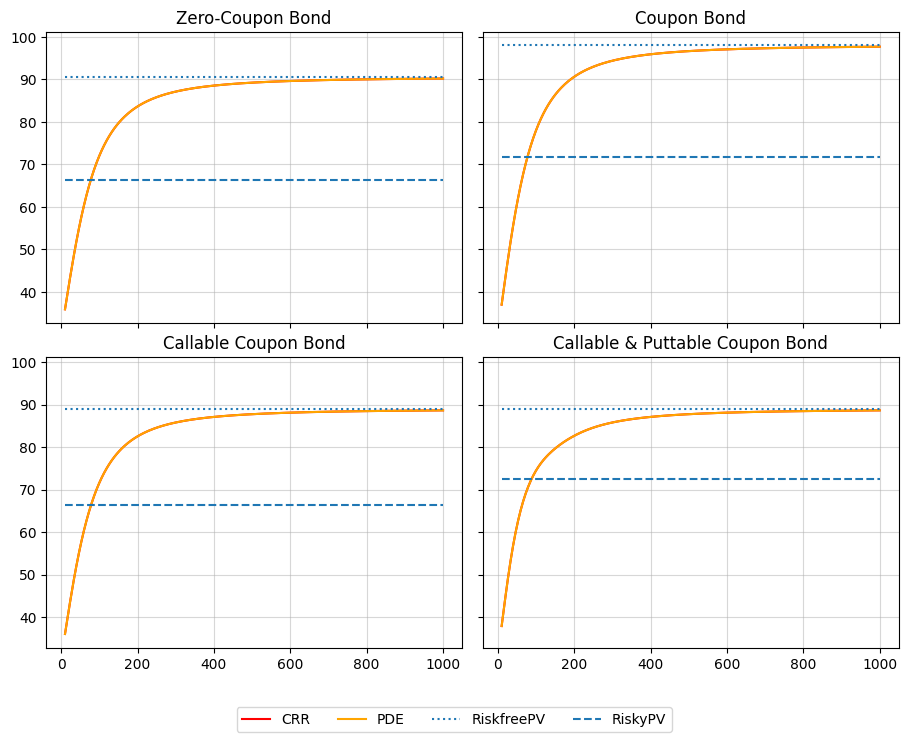

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey=True)

subplot_map = {
    "ZB": [0, 0, "Zero-Coupon Bond"],
    "CB": [0, 1, "Coupon Bond"],
    "CCB": [1, 0, "Callable Coupon Bond"],
    "CPCB": [1, 1, "Callable & Puttable Coupon Bond"],
}
for ctype, d in price_ladder.items():
    row = subplot_map[ctype][0]
    col = subplot_map[ctype][1]
    title = subplot_map[ctype][2]
    for model, ladder in d.items():
        linestyle = ":" if model == "RiskfreePV" else "--" if model == "RiskyPV" else "-"
        color = "red" if model == "CRR" else "orange" if model == "PDE" else "#1f77b4"
        axes[row, col].plot(stock_ladder, ladder, label=model, linestyle=linestyle, color=color)
    axes[row, col].set_title(title)
    axes[row, col].grid(alpha=0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center")
fig.subplots_adjust(wspace=0.05, hspace=0.12)

Converts

In [9]:
maturity = 1.0
face_value = 100
coupon_schedule = {0.25: 3.0, 0.5: 3.0, 0.75: 3.0, 1.0: 3.0}
conversion_schedule = {(0, 1): 1}
call_schedule = {(0.3, 0.8): 100}
softcall_schedule = {(0.3, 0.8): (120, 100)}
put_schedule = {(0.3, 0.8): 90}
call_notice_period = 60
call_cushion = 0.5
call_cushion_prob_1m = 0.5
recovery_rate = 0.3
recovery_type = "par"
stock_price = 100
equity_vol = 0.3
riskless_rate = 0.03
dividend_yield = 0.0
default_intensity = 0.05
equity_to_credit = 1.5
stock_ladder = np.linspace(10.0, stock_price * 3.0, 500)
price_ladder = {}

In [10]:
%%time
# Model
crr_model = BinomialTree(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    spline_size=500,
    time_size=1000,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
pde_model = PDE(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    time_size=1000,
    space_size=3000,
    min_space=120.0,
    max_space=120,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
# Security
zc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule={},
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule={},
    call_notice_period=call_notice_period,
    call_cushion=call_cushion,
    call_cushion_prob_1m=call_cushion_prob_1m,
    put_schedule={},
    dividend_protection={},
)
cc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule={},
    call_notice_period=call_notice_period,
    call_cushion=call_cushion,
    call_cushion_prob_1m=call_cushion_prob_1m,
    put_schedule={},
    dividend_protection={},
)
ccc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=call_schedule,
    call_notice_period=0,
    call_cushion=0,
    call_cushion_prob_1m=0,
    put_schedule={},
    dividend_protection={},
)
sccc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=softcall_schedule,
    call_notice_period=0,
    call_cushion=0,
    call_cushion_prob_1m=0,
    put_schedule={},
    dividend_protection={},
)
cncc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=call_schedule,
    call_notice_period=call_notice_period,
    call_cushion=0,
    call_cushion_prob_1m=0,
    put_schedule={},
    dividend_protection={},
)
cndcc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=call_schedule,
    call_notice_period=call_notice_period,
    call_cushion=call_cushion,
    call_cushion_prob_1m=call_cushion_prob_1m,
    put_schedule={},
    dividend_protection={},
)
cpcc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=call_schedule,
    call_notice_period=0,
    call_cushion=0,
    call_cushion_prob_1m=0,
    put_schedule=put_schedule,
    dividend_protection={},
)
rc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=softcall_schedule,
    call_notice_period=call_notice_period,
    call_cushion=call_cushion,
    call_cushion_prob_1m=call_cushion_prob_1m,
    put_schedule=put_schedule,
    dividend_protection={},
)
# Pricing
price_ladder["ZC"] = {}
price_ladder["ZC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(zc)[0])
price_ladder["ZC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(zc)[0])
price_ladder["ZC"]["Parity"] = stock_ladder * Event(crr_model, zc).conversion_event.cr[0]
price_ladder["ZC"]["BondFloor"] = np.full_like(stock_ladder, zc.get_risky_bond_floor(crr_model, Event(crr_model, zc))[0])

price_ladder["CC"] = {}
price_ladder["CC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cc)[0])
price_ladder["CC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cc)[0])
price_ladder["CC"]["Parity"] = stock_ladder * Event(crr_model, cc).conversion_event.cr[0]
price_ladder["CC"]["BondFloor"] = np.full_like(stock_ladder, cc.get_risky_bond_floor(crr_model, Event(crr_model, cc))[0])

price_ladder["CCC"] = {}
price_ladder["CCC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(ccc)[0])
price_ladder["CCC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(ccc)[0])
price_ladder["CCC"]["Parity"] = stock_ladder * Event(crr_model, ccc).conversion_event.cr[0]
price_ladder["CCC"]["BondFloor"] = np.full_like(stock_ladder, ccc.get_risky_bond_floor(crr_model, Event(crr_model, ccc))[0])

price_ladder["SCCC"] = {}
price_ladder["SCCC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(sccc)[0])
price_ladder["SCCC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(sccc)[0])
price_ladder["SCCC"]["Parity"] = stock_ladder * Event(crr_model, sccc).conversion_event.cr[0]
price_ladder["SCCC"]["BondFloor"] = np.full_like(stock_ladder, sccc.get_risky_bond_floor(crr_model, Event(crr_model, sccc))[0])

price_ladder["CNCC"] = {}
price_ladder["CNCC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cncc)[0])
price_ladder["CNCC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cncc)[0])
price_ladder["CNCC"]["Parity"] = stock_ladder * Event(crr_model, cncc).conversion_event.cr[0]
price_ladder["CNCC"]["BondFloor"] = np.full_like(stock_ladder, cncc.get_risky_bond_floor(crr_model, Event(crr_model, cncc))[0])

price_ladder["CNDCC"] = {}
price_ladder["CNDCC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cndcc)[0])
price_ladder["CNDCC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cndcc)[0])
price_ladder["CNDCC"]["Parity"] = stock_ladder * Event(crr_model, cndcc).conversion_event.cr[0]
price_ladder["CNDCC"]["BondFloor"] = np.full_like(stock_ladder, cndcc.get_risky_bond_floor(crr_model, Event(crr_model, cndcc))[0])

price_ladder["CPCC"] = {}
price_ladder["CPCC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(cpcc)[0])
price_ladder["CPCC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(cpcc)[0])
price_ladder["CPCC"]["Parity"] = stock_ladder * Event(crr_model, cpcc).conversion_event.cr[0]
price_ladder["CPCC"]["BondFloor"] = np.full_like(stock_ladder, cpcc.get_risky_bond_floor(crr_model, Event(crr_model, cpcc))[0])

price_ladder["RC"] = {}
price_ladder["RC"]["CRR"] = np.interp(stock_ladder, crr_model.stock_grid[0], crr_model.price(rc)[0])
price_ladder["RC"]["PDE"] = np.interp(stock_ladder, pde_model.stock_grid[0], pde_model.price(rc)[0])
price_ladder["RC"]["Parity"] = stock_ladder * Event(crr_model, rc).conversion_event.cr[0]
price_ladder["RC"]["BondFloor"] = np.full_like(stock_ladder, rc.get_risky_bond_floor(crr_model, Event(crr_model, rc))[0])

CPU times: total: 6.38 s
Wall time: 6.39 s


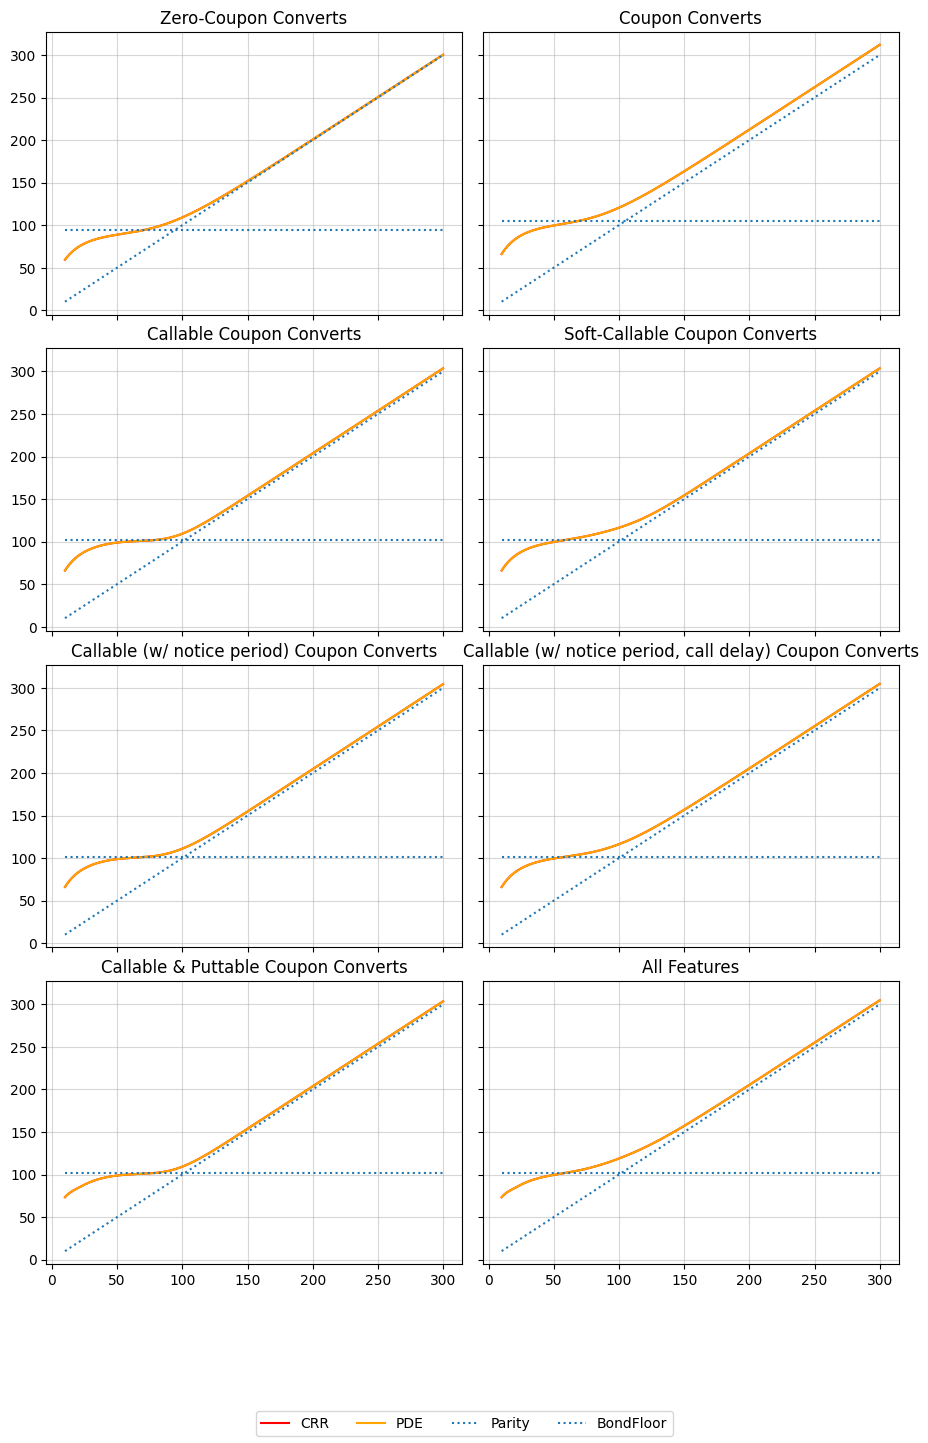

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(11, 16), sharex=True, sharey=True)

subplot_map = {
    "ZC": [0, 0, "Zero-Coupon Converts"],
    "CC": [0, 1, "Coupon Converts"],
    "CCC": [1, 0, "Callable Coupon Converts"],
    "SCCC": [1, 1, "Soft-Callable Coupon Converts"],
    "CNCC": [2, 0, "Callable (w/ notice period) Coupon Converts"],
    "CNDCC": [2, 1, "Callable (w/ notice period, call delay) Coupon Converts"],
    "CPCC": [3, 0, "Callable & Puttable Coupon Converts"],
    "RC": [3, 1, "All Features"],
}
for ctype, d in price_ladder.items():
    row = subplot_map[ctype][0]
    col = subplot_map[ctype][1]
    title = subplot_map[ctype][2]
    for model, ladder in d.items():
        linestyle = ":" if model in ["Parity", "BondFloor"] else "-"
        color = "red" if model == "CRR" else "orange" if model == "PDE" else "#1f77b4"
        axes[row, col].plot(stock_ladder, ladder, label=model, linestyle=linestyle, color=color)
    axes[row, col].set_title(title)
    axes[row, col].grid(alpha=0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center")
fig.subplots_adjust(wspace=0.05, hspace=0.12)

In [12]:
table = []
for ctype, d in price_ladder.items():
    first = subplot_map[ctype][2]
    second = round(np.interp(stock_price, stock_ladder, d["CRR"]), 2)
    third = round(np.interp(stock_price, stock_ladder, d["PDE"]), 2)
    table.append([first, second, third])
table = pd.DataFrame(table, columns=["Features","CRR","PDE"])
table

,Features,CRR,PDE
0,Zero-Coupon Converts,109.04,109.04
1,Coupon Converts,120.46,120.46
2,Callable Coupon Converts,109.27,109.25
3,Soft-Callable Coupon Converts,116.30,116.21
4,Callable (w/ notice period) Coupon Converts,111.08,111.07
5,"Callable (w/ notice period, call delay) Coupon...",116.32,116.31
6,Callable & Puttable Coupon Converts,109.27,109.25
7,All Features,118.84,118.81


Probabilities (Converts Only)

In [13]:
maturity = 1.0
face_value = 100
coupon_schedule = {0.25: 3.0, 0.5: 3.0, 0.75: 3.0, 1.0: 3.0}
conversion_schedule = {(0, 1): 1}
call_schedule = {(0.3, 0.8): (120, 100)}
put_schedule = {(0.3, 0.8): 80}
call_notice_period = 60
call_cushion = 0.5
call_cushion_prob_1m = 0.5
recovery_rate = 0.3
recovery_type = "par"
stock_price = 100
equity_vol = 0.3
riskless_rate = 0.05
dividend_yield = 0.03
default_intensity = 0.05
equity_to_credit = 1.5
stock_ladder = np.linspace(0.1, stock_price * 3, 500)
price_ladder = {}

In [14]:
%%time
# Model
crr_model = BinomialTree(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    spline_size=500,
    time_size=1000,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
pde_model = PDE(
    max_years=maturity,
    stock_price=stock_price,
    equity_vol=equity_vol,
    riskless_rate=riskless_rate,
    dividend_yield=dividend_yield,
    cash_dividend={},
    time_size=1000,
    space_size=3000,
    min_space=120.0,
    max_space=120,
    default_intensity=default_intensity,
    equity_to_credit=equity_to_credit,
)
# Secutity
rc = ConvertibleBond(
    maturity=maturity,
    face_value=face_value,
    coupon_schedule=coupon_schedule,
    recovery_rate=recovery_rate,
    recovery_type=recovery_type,
    conversion_schedule=conversion_schedule,
    call_schedule=call_schedule,
    call_notice_period=call_notice_period,
    call_cushion=call_cushion,
    call_cushion_prob_1m=call_cushion_prob_1m,
    put_schedule=put_schedule,
    dividend_protection={},
)
# Pricing
analytics_to_price = [
    DefaultProbability,
    OptionalConvProbability,
    MaturityConvProbability,
    CallRedemptionProbability,
    ForcedConvProbability,
    PutProbability,
    MaturityRedemptionProbability,
]
crr_res = crr_model.price(rc, analytics_to_price=analytics_to_price, debug_mode=True)
pde_res = pde_model.price(rc, analytics_to_price=analytics_to_price, debug_mode=True)
price_ladder["sum_prob"] = {
    "CRR": np.zeros_like(stock_ladder),
    "PDE": np.zeros_like(stock_ladder),
}
for analytics in analytics_to_price:
    price_ladder[analytics.to_string()] = {
        "CRR": np.interp(stock_ladder, crr_model.stock_grid[0], crr_res[analytics.to_string()]["solution"][0]),
        "PDE": np.interp(stock_ladder, pde_model.stock_grid[0], pde_res[analytics.to_string()]["solution"][0]),
    }
    price_ladder["sum_prob"]["CRR"] += price_ladder[analytics.to_string()]["CRR"]
    price_ladder["sum_prob"]["PDE"] += price_ladder[analytics.to_string()]["PDE"]

CPU times: total: 8.2 s
Wall time: 8.23 s


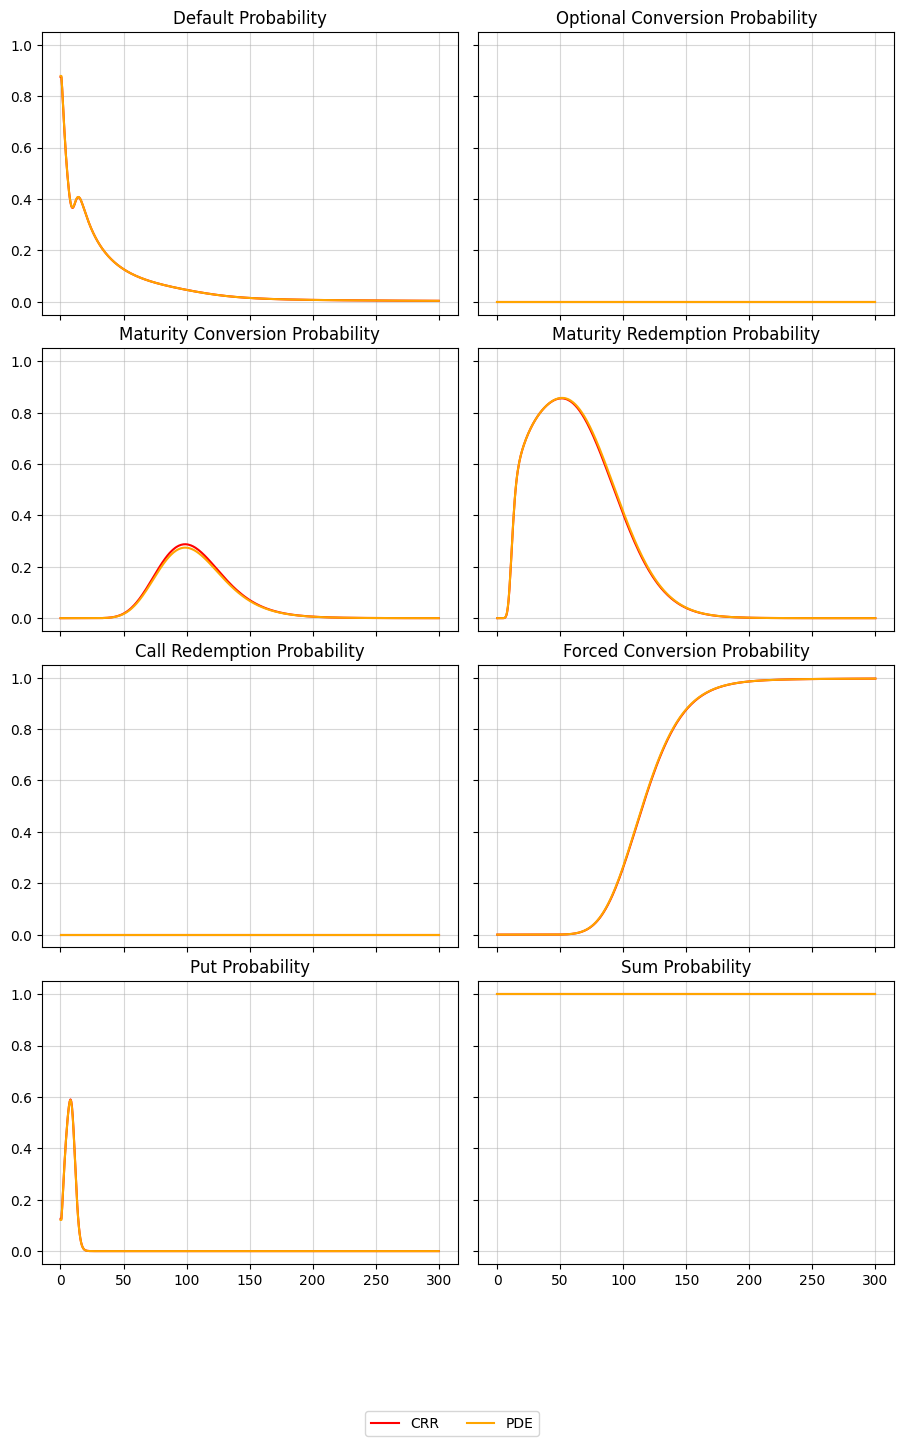

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(11, 16), sharex=True, sharey=True)

subplot_map = {
    "default_prob": [0, 0, "Default Probability"],
    "optional_conv_prob": [0, 1, "Optional Conversion Probability"],
    "maturity_conv_prob": [1, 0, "Maturity Conversion Probability"],
    "maturity_redemption_prob": [1, 1, "Maturity Redemption Probability"],
    "call_redemption_prob":  [2, 0, "Call Redemption Probability"],
    "forced_conv_prob": [2, 1, "Forced Conversion Probability"],
    "put_prob": [3, 0, "Put Probability"],
    "sum_prob": [3, 1, "Sum Probability"],
}
for ctype, d in price_ladder.items():
    row = subplot_map[ctype][0]
    col = subplot_map[ctype][1]
    title = subplot_map[ctype][2]
    for model, ladder in d.items():
        color = "red" if model == "CRR" else "orange" if model == "PDE" else "#1f77b4"
        axes[row, col].plot(stock_ladder, ladder, label=model, color=color)
    axes[row, col].set_title(title)
    axes[row, col].grid(alpha=0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc="lower center")
fig.subplots_adjust(wspace=0.05, hspace=0.12)

Calibration (PDE only)

In [16]:
%%time
vol_ts, skew_6m, skew_5y, spread_ts = {}, {}, {}, {}
params = [
    # vol, lambda, e2c, in graph 1-8
    (0.3, 0.05, 0.0, False, True, False, False, True, False, True, False),
    (0.3, 0.05, 0.5, False, True, False, False, False, False, False, False),
    (0.3, 0.0, 2.0, True, False, False, False, False, False, False, False),
    (0.3, 0.02, 2.0, False, False, True, True, False, True, False, False),
    (0.3, 0.03, 2.0, True, False, False, False, False, False, False, False),
    (0.3, 0.05, 2.0, True, True, True, True, True, True, True, False),
    (0.3, 0.1, 2.0, True, False, True, True, False, True, False, True),
    (0.15, 0.1, 2.0, False, False, False, False, False, False, False, True),
    (0.5, 0.1, 2.0, False, False, False, False, False, False, False, True),
    (0.3, 0.05, 3.0, False, False, False, False, False, False, True, False),
]
strikes = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
tenors = [0.3, 0.6] + list(range(1, 13))
for i, param in enumerate(params):
    print(f"{i+1}|{len(params)}: {param}")
    model = PDE(
        max_years=12,
        stock_price=50,
        equity_vol=param[0],
        riskless_rate=0.04,
        dividend_yield=0.02,
        cash_dividend={},
        time_size=800,
        space_size=800,
        min_space=120,
        max_space=120,
        default_intensity=param[1],
        equity_to_credit=param[2],
    )
    if param[3] or param[4]:
        vol_ts[param] = calculator.get_vol_term_structure(model, tenors)
    if param[5]:
        skew_6m[param] = calculator.get_vol_skew(model, tenor=0.5, strikes=strikes)
    if param[6] or param[7]:
        skew_5y[param] = calculator.get_vol_skew(model, tenor=5.0, strikes=strikes)
    if param[8] or param[9] or param[10]:
        spread_ts[param] = calculator.get_spread_term_structure(model, tenors)

1|10: (0.3, 0.05, 0.0, False, True, False, False, True, False, True, False)
2|10: (0.3, 0.05, 0.5, False, True, False, False, False, False, False, False)
3|10: (0.3, 0.0, 2.0, True, False, False, False, False, False, False, False)
4|10: (0.3, 0.02, 2.0, False, False, True, True, False, True, False, False)
5|10: (0.3, 0.03, 2.0, True, False, False, False, False, False, False, False)
6|10: (0.3, 0.05, 2.0, True, True, True, True, True, True, True, False)
7|10: (0.3, 0.1, 2.0, True, False, True, True, False, True, False, True)
8|10: (0.15, 0.1, 2.0, False, False, False, False, False, False, False, True)
9|10: (0.5, 0.1, 2.0, False, False, False, False, False, False, False, True)
10|10: (0.3, 0.05, 3.0, False, False, False, False, False, False, True, False)
CPU times: total: 22.2 s
Wall time: 22.4 s


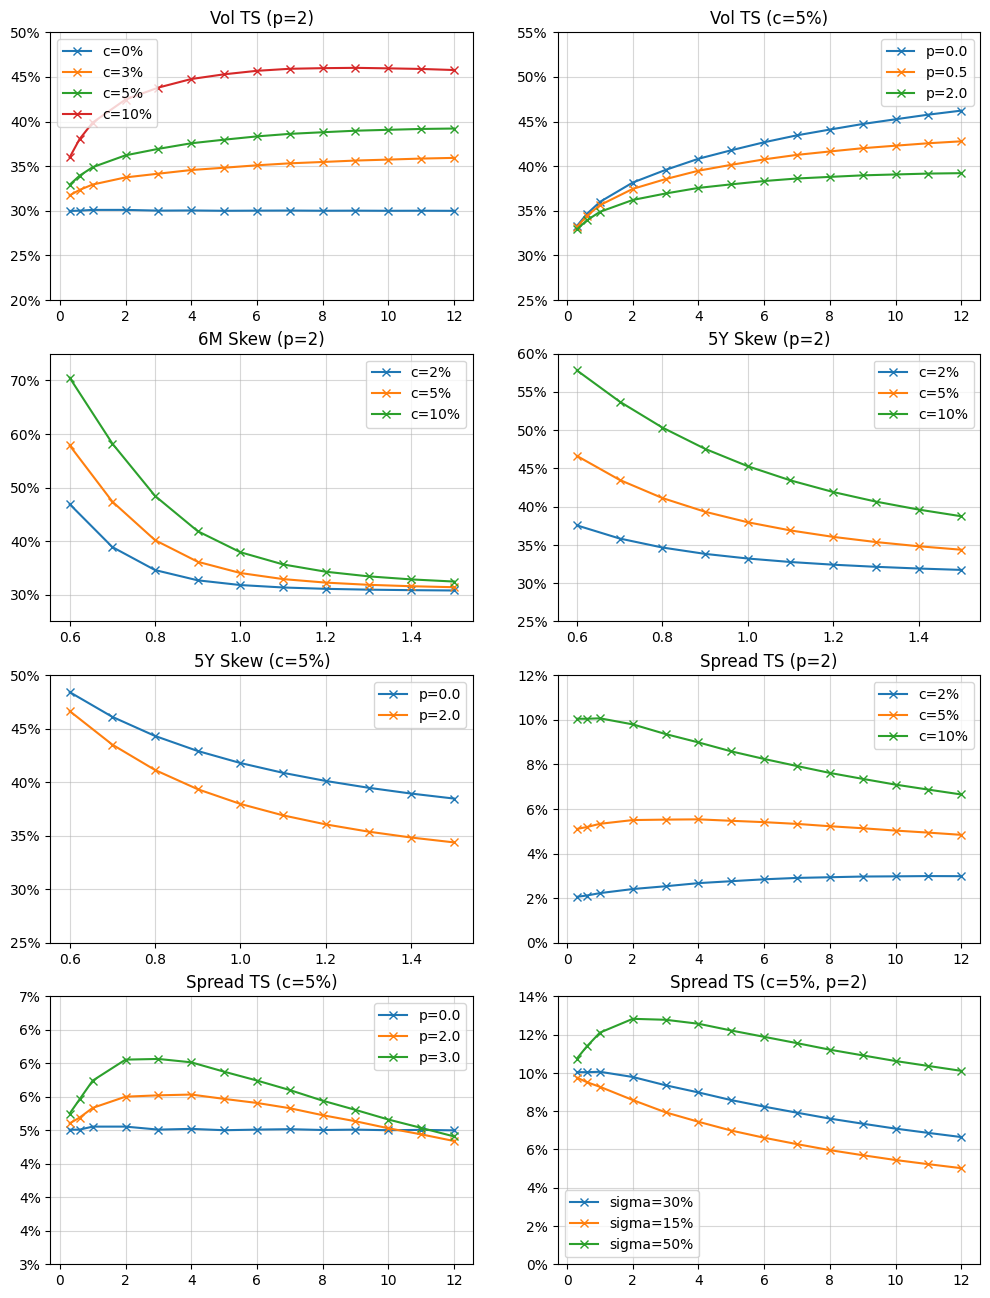

In [17]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for param in params:
    if param[3]:
        axes[0, 0].plot(pd.Series(vol_ts[param]), marker="x", label=f"c={param[1]:.0%}")
    if param[4]:
        axes[0, 1].plot(pd.Series(vol_ts[param]), marker="x", label=f"p={param[2]:.1f}")
    if param[5]:
        axes[1, 0].plot(pd.Series(skew_6m[param]), marker="x", label=f"c={param[1]:.0%}")
    if param[6]:
        axes[1, 1].plot(pd.Series(skew_5y[param]), marker="x", label=f"c={param[1]:.0%}")
    if param[7]:
        axes[2, 0].plot(pd.Series(skew_5y[param]), marker="x", label=f"p={param[2]:.1f}")
    if param[8]:
        axes[2, 1].plot(pd.Series(spread_ts[param]), marker="x", label=f"c={param[1]:.0%}")
    if param[9]:
        axes[3, 0].plot(pd.Series(spread_ts[param]), marker="x", label=f"p={param[2]:.1f}")
    if param[10]:
        axes[3, 1].plot(pd.Series(spread_ts[param]), marker="x", label=f"sigma={param[0]:.0%}")
axes[0, 0].set_ylim(0.2, 0.5)
axes[0, 0].grid(alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_title("Vol TS (p=2)")
axes[0, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[0, 1].set_ylim(0.25, 0.55)
axes[0, 1].grid(alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_title("Vol TS (c=5%)")
axes[0, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[1, 0].set_ylim(0.25, 0.75)
axes[1, 0].grid(alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_title("6M Skew (p=2)")
axes[1, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[1, 1].set_ylim(0.25, 0.6)
axes[1, 1].grid(alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_title("5Y Skew (p=2)")
axes[1, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[2, 0].set_ylim(0.25, 0.5)
axes[2, 0].grid(alpha=0.5)
axes[2, 0].legend()
axes[2, 0].set_title("5Y Skew (c=5%)")
axes[2, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[2, 1].set_ylim(0, 0.12)
axes[2, 1].grid(alpha=0.5)
axes[2, 1].legend()
axes[2, 1].set_title("Spread TS (p=2)")
axes[2, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[3, 0].set_ylim(0.03, 0.07)
axes[3, 0].grid(alpha=0.5)
axes[3, 0].legend()
axes[3, 0].set_title("Spread TS (c=5%)")
axes[3, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

axes[3, 1].set_ylim(0, 0.14)
axes[3, 1].grid(alpha=0.5)
axes[3, 1].legend()
axes[3, 1].set_title("Spread TS (c=5%, p=2)")
axes[3, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

In [18]:
%%time
result, old_vol, new_vol, old_spread, new_spread = {}, {}, {}, {}, {}
e2cs = [0, 0.5, 1, 2.0]
for i, e2c in enumerate(e2cs):
    print(f"{i+1}|{len(e2cs)}: {e2c}")
    model = PDE(
        max_years=12.0,
        stock_price=50,
        equity_vol=0.3,
        riskless_rate=0.04,
        dividend_yield=0.02,
        cash_dividend={},
        time_size=800,
        space_size=800,
        min_space=70,
        max_space=70,
        default_intensity=0.05,
        equity_to_credit=e2c,
        calibration_target=[(1/12 * i, 0.05, 0.4) for i in range(1, 144)],
        calibration_scheme="rannacher",
    )
    res, new_model = model.calibrate(raise_error=False)
    result[e2c] = res
    if not res["error"]:
        old_vol[e2c] = calculator.get_vol_term_structure(model, list(range(1, 144)))
        old_spread[e2c] = calculator.get_spread_term_structure(model, list(range(1, 144)))
        new_vol[e2c] = calculator.get_vol_term_structure(new_model, list(range(1, 144)))
        new_spread[e2c] = calculator.get_spread_term_structure(new_model, list(range(1, 144)))

1|4: 0
2|4: 0.5
3|4: 1
4|4: 2.0
CPU times: total: 45.5 s
Wall time: 45.7 s


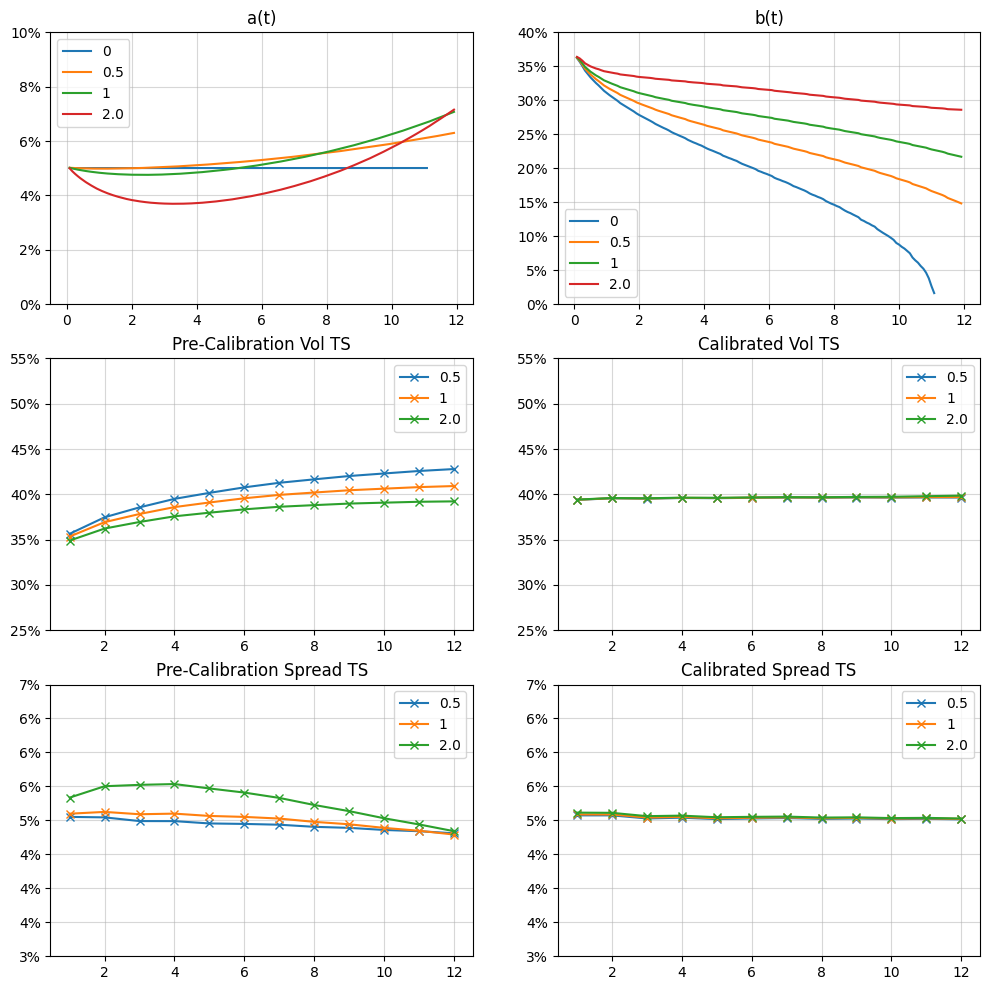

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for p, r in result.items(): 
    axes[0, 0].plot(pd.Series(r["ats"]), label=p)
axes[0, 0].set_ylim(0, 0.1)
axes[0, 0].grid(alpha=0.5)
axes[0, 0].legend()
axes[0, 0].set_title("a(t)")
axes[0, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

for p, r in result.items(): 
    axes[0, 1].plot(pd.Series(r["bts"]), label=p)
axes[0, 1].set_ylim(0, 0.4)
axes[0, 1].grid(alpha=0.5)
axes[0, 1].legend()
axes[0, 1].set_title("b(t)")
axes[0, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

for p, ts in old_vol.items(): 
    axes[1, 0].plot(pd.Series(ts), label=p, marker="x")
axes[1, 0].set_ylim(0.25, 0.55)
axes[1, 0].grid(alpha=0.5)
axes[1, 0].legend()
axes[1, 0].set_title("Pre-Calibration Vol TS")
axes[1, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

for p, ts in new_vol.items(): 
    axes[1, 1].plot(pd.Series(ts), label=p, marker="x")
axes[1, 1].set_ylim(0.25, 0.55)
axes[1, 1].grid(alpha=0.5)
axes[1, 1].legend()
axes[1, 1].set_title("Calibrated Vol TS")
axes[1, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

for p, ts in old_spread.items(): 
    axes[2, 0].plot(pd.Series(ts), label=p, marker="x")
axes[2, 0].set_ylim(0.03, 0.07)
axes[2, 0].grid(alpha=0.5)
axes[2, 0].legend()
axes[2, 0].set_title("Pre-Calibration Spread TS")
axes[2, 0].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

for p, ts in new_spread.items(): 
    axes[2, 1].plot(pd.Series(ts), label=p, marker="x")
axes[2, 1].set_ylim(0.03, 0.07)
axes[2, 1].grid(alpha=0.5)
axes[2, 1].legend()
axes[2, 1].set_title("Calibrated Spread TS")
axes[2, 1].yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))